## Introduction

With the advent of cryptocurrencies the world of economics will not be the same anylonger. To quote Napoleon: _"A revolution can neither be created nor stoped"_. Cryptos are becoming an intergral part of the industry, and along with Blockchain technology, they provide great topics for research, both in academia and outside of it. 

On the other end of the spectrum, the tremendous increase in computational power, especially over the last decade, combined with an abundance of collected data, has enabled AI researchers to test their early and ongoing theories about various neural network architectures. This in turn has created the so called Deep Learning field in AI. 

For newbies, I definetly recommend [this](http://index-of.es/Varios-2/Hands%20on%20Machine%20Learning%20with%20Scikit%20Learn%20and%20Tensorflow.pdf) book, which gives you exactly what you need for getting into DL even without extensive knowledge of math (although I admitt, prior knowledge on stats makes the learning process smoother).

Going further, I was really interested in both of them. I had some prior knowledge on neural networks (specifically MLP), but not at all on Bitcoin. However, I would listen to news about cryptocurrencies and bitcoin nonstop on BBC worldwide, youtube, twitter, and was really frustrated with my small understanding of it. Therefore I decided to merge Bitcoin with AI, by predicting the price of Ethereum and Bitcoin, so as to get the best of both worlds. 

Just to keep in mind: there are a lot more interesting stuff about bitcoin that the price! I will provide a list with some references about the Bitcoin invention. 


For this work, I have utilized the LSTM neural network, since it is created exactly for time-series problems, unlike MLP. I will predict bitcoin and ethereum. The reason being that, there is more data for bitcoin than there is for other cryptos, bitcoin was the first  crypto introducing us the blockchain, decentralized digital cash etc. On the other hand, I was interested in getting to know Smart Contracts, and how ethereum used bitcoin to create a complete other novel invention. 

### Data

I have used daily prices of Bitcoin, although some use minute-by-minute data, I believe there would be much overfitting that way. I use [coinmarketcap.com](https://coinmarketcap.com) to fetch the data on both ether and bitcoin. 

In [64]:
import pandas as pd
import time
import seaborn as sns
import datetime
from datetime import date, timedelta
import numpy as np

# We get BTC Exchange data from 2013 until 2 days before (for consistency matter)
yesterday = (date.today() - timedelta(2)).strftime('%Y%m%d')
# Bitcoin market data since 2013
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+yesterday)[0]
# Convert Date from string to Datetime type
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# Convert Volume to 0 when its '-'
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# Convert Volume to int type
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# Remove asterisks from Name column
bitcoin_market_info.columns = bitcoin_market_info.columns.str.replace("*", "")
# Get a glimpse of it:
print(bitcoin_market_info.head())

        Date     Open     High      Low    Close      Volume    Market Cap
0 2018-09-12  6317.01  6363.87  6265.09  6351.80  4064230000  109047547377
1 2018-09-11  6331.88  6398.92  6260.21  6321.20  3849910000  109293238395
2 2018-09-10  6301.57  6374.98  6292.76  6329.70  3714100000  108759350260
3 2018-09-09  6223.38  6446.26  6201.22  6300.86  3671890000  107397286192
4 2018-09-08  6460.17  6534.25  6197.52  6225.98  3835060000  111471362532


In [65]:
# Same for ether
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+yesterday)[0]
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
eth_market_info.columns = eth_market_info.columns.str.replace("*", "")

The data is fetched from [coinmarketcap](https://coinmarketcap.com/currencies/bitcoin/historical-data/). As usual we have to do a bit of data cleaning. 
Just to prove that the data is accurate, we can plot the price and volume of both cryptocurrencies over time.

In [66]:
# getting the Bitcoin and Eth logos
import sys
from PIL import Image
import io

if sys.version_info[0] < 3:
    import urllib2 as urllib
    bt_img = urllib.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
    eth_img = urllib.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")
else:
    import urllib
    bt_img = urllib.request.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
    eth_img = urllib.request.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")

image_file = io.BytesIO(bt_img.read())
bitcoin_im = Image.open(image_file)

image_file = io.BytesIO(eth_img.read())
eth_im = Image.open(image_file)
width_eth_im , height_eth_im  = eth_im.size
eth_im = eth_im.resize((int(eth_im.size[0]*0.8), int(eth_im.size[1]*0.8)), Image.ANTIALIAS)

In [67]:
# Getting Blockchain data
import urllib2 as urllib
import time
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
import numpy as np

# Get the average block size from blockchain.info; max size ==> 1 MB (by design)
avg_block_size = pd.read_csv(urllib.urlopen("https://blockchain.info/charts/avg-block-size?timespan=all&format=csv"))
# Format columns
avg_block_size = pd.DataFrame(avg_block_size.values, columns=['date', 'avg_block_size'])
avg_block_size['date'] = pd.to_datetime(avg_block_size['date'], format='%Y-%m-%d')
avg_block_size['date'] = pd.DataFrame(data=avg_block_size['date'], columns=['date'])

avg_block_size['date'] = pd.to_datetime(avg_block_size['date'])

# Add dates that do not appear at all, because their blocksize was same as the day before
avg_block_size = avg_block_size.set_index('date').resample('D').ffill()

# Reset index
avg_block_size.index.name='date'
data = avg_block_size.reset_index()
avg_block_size = data

# Drop values before 2013, to be consistent with BTC Exchange dataset
avg_block_size = avg_block_size.drop(avg_block_size[avg_block_size['date'] < '2013-04-28'].index)
avg_block_size = avg_block_size.reset_index(drop=True)

In [68]:
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]

# Convert to numpy array 
# bitcoin_dates = bitcoin_market_info.values[:,0]
# # Convert the dates column from np array to pandas dataframe
# pd_bitcoin_dates = pd.DataFrame(bitcoin_market_info.values[:,0],columns=['date'])
# # print(pd_bitcoin_dates)

# # df = pd.DataFrame(data=avg_block_size['date'], columns=['date'])
# # date_rng = pd.date_range(start='2013-04-28', end=time.strftime("%Y-%m-%d"), freq='D')
# # range_dates = pd.DataFrame(date_rng, columns=['date'])

# # mergedStuff = pd.merge(pd_bitcoin_dates,range_dates, on="date")
# # mergedStuff.head()

# # Convert to Datetime from String
# pd_bitcoin_dates['date'] = pd.to_datetime(pd_bitcoin_dates['date'], format='%Y-%m-%d')
# # pd.to_datetime(pd_bitcoin_dates[:])
# pd_bitcoin_dates.set_index('date')
# print(bitcoin_market_info)
# missing_pd_bitcoin_dates = set(pd_bitcoin_dates.date).symmetric_difference(df.date)

# # Hopefully we have no missing dates
# if missing_pd_bitcoin_dates != set():
#     print('Missing Bitcoin Date from Exchange: ' + str(missing_pd_bitcoin_dates))

# Save to csv
# pd_bitcoin_dates.to_csv('pd_bitcoin_dates.csv')
# df.to_csv('df.csv')

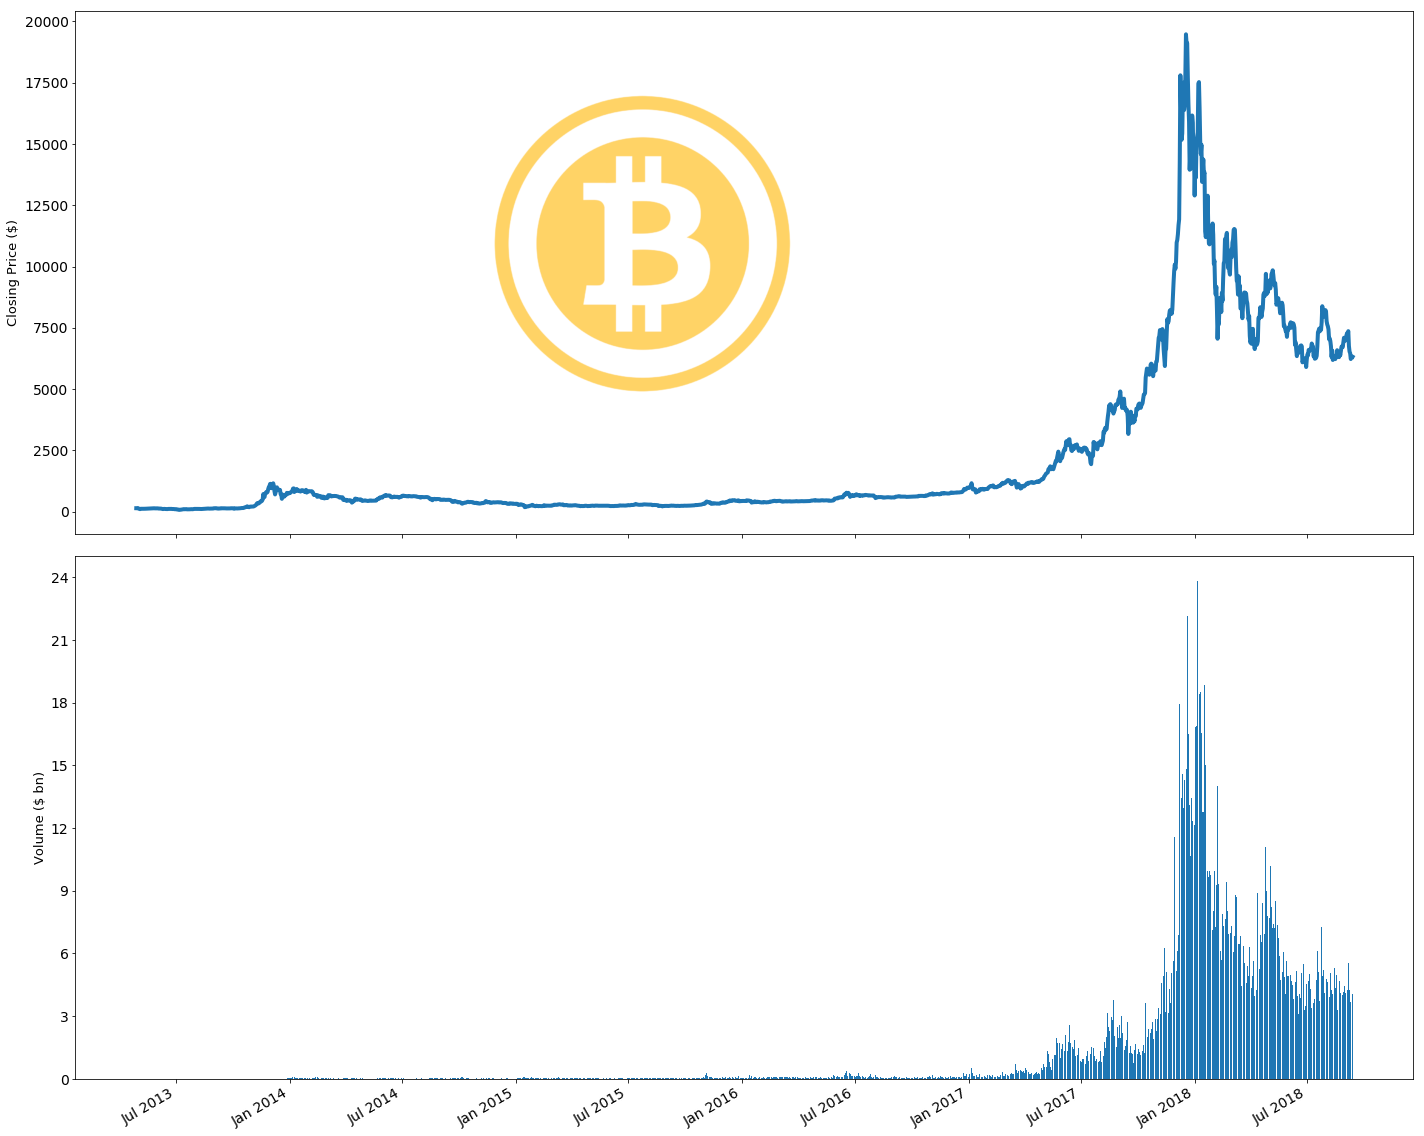

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline  
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 14
rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)

fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[5, 5]} )
fig.autofmt_xdate()

ax1.set_ylabel('Closing Price ($)',fontsize=13)
ax2.set_ylabel('Volume ($ bn)',fontsize=13)
ax2.set_yticks([int('%d000000000'%i) for i in range(0, 25, 3)])
ax2.set_yticklabels(range(0, 25, 3))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(bitcoin_market_info['Date'].astype(datetime.datetime),bitcoin_market_info['bt_Open'])
ax2.bar(bitcoin_market_info['Date'].astype(datetime.datetime).values, bitcoin_market_info['bt_Volume'].values)
fig.tight_layout()

# print(bitcoin_market_info['bt_Volume'].values.max())
fig.figimage(bitcoin_im, 320, 650, zorder=3, alpha=.6)
plt.plot(subplots=True)
# Set BG color
# ax = plt.gca()
# ax.set_facecolor('xkcd:salmon')
# ax.set_facecolor((1.0, 0.47, 0.42))
# plt.grid(True)
plt.show()

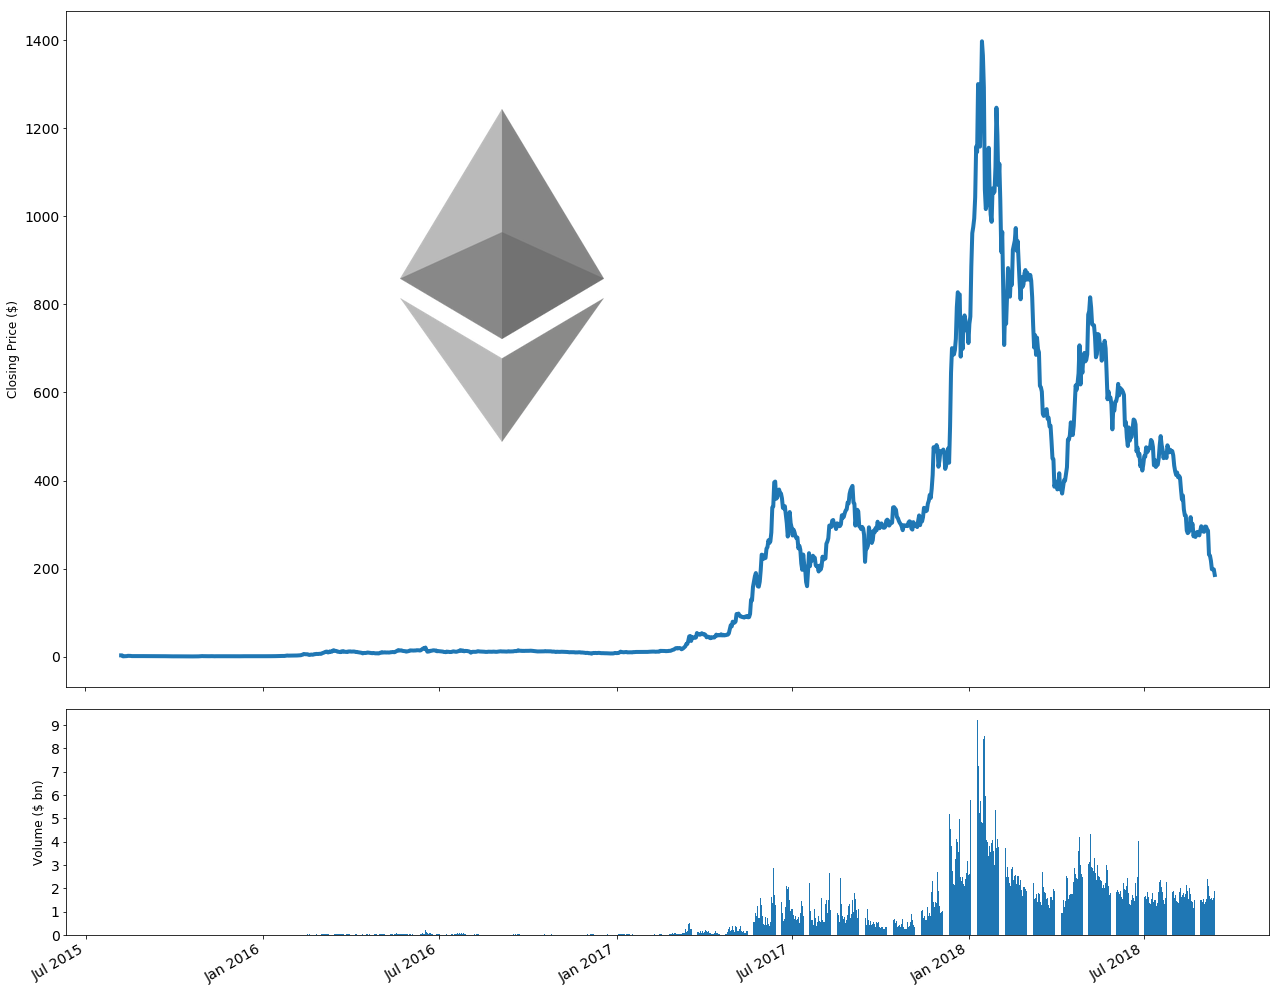

<Figure size 640x480 with 0 Axes>

In [73]:
from matplotlib.pyplot import figure
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 14
rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (18, 14)
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
#ax1.set_yscale('log')
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
fig.autofmt_xdate()
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(eth_market_info['Date'].astype(datetime.datetime),eth_market_info['eth_Open'])
ax2.bar(eth_market_info['Date'].astype(datetime.datetime).values, eth_market_info['eth_Volume'].values)
fig.tight_layout()
fig.figimage(eth_im, 400, 550, zorder=3, alpha=.6)
plt.show()

In [74]:
market_info = pd.merge(bitcoin_market_info,eth_market_info, on=['Date'])
market_info = market_info[market_info['Date']>='2016-01-01']
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff
0,2018-09-12,6317.01,6363.87,6265.09,6351.80,4064230000,109047547377,185.42,185.59,170.26,183.33,1874850000,18894773430,0.005507,-0.011272
1,2018-09-11,6331.88,6398.92,6260.21,6321.20,3849910000,109293238395,198.18,198.51,180.60,185.07,1568900000,20190354865,-0.001687,-0.066152
2,2018-09-10,6301.57,6374.98,6292.76,6329.70,3714100000,108759350260,197.85,201.88,189.58,197.08,1502960000,20153125179,0.004464,-0.003892
3,2018-09-09,6223.38,6446.26,6201.22,6300.86,3671890000,107397286192,198.38,207.67,188.31,196.92,1585980000,20203492382,0.012450,-0.007360
4,2018-09-08,6460.17,6534.25,6197.52,6225.98,3835060000,111471362532,217.91,220.37,193.26,197.95,1517200000,22187693065,-0.036251,-0.091597


### Training, Test

Typically the test data gets split into training, test, and validation data sets. The model is built using the training set, afterwards, the test set is used to evaluate the model. 
We generally train on one period of time and then test on another separate period. Rather arbitrary, I'll set the cut-off date to February 1st 2018. The model will be trained on data before that date (unfortunately we'll have to make use even of data on 2013-2015 when Bitcoin wasn't that popular), and after this the remaining is left for testing :)

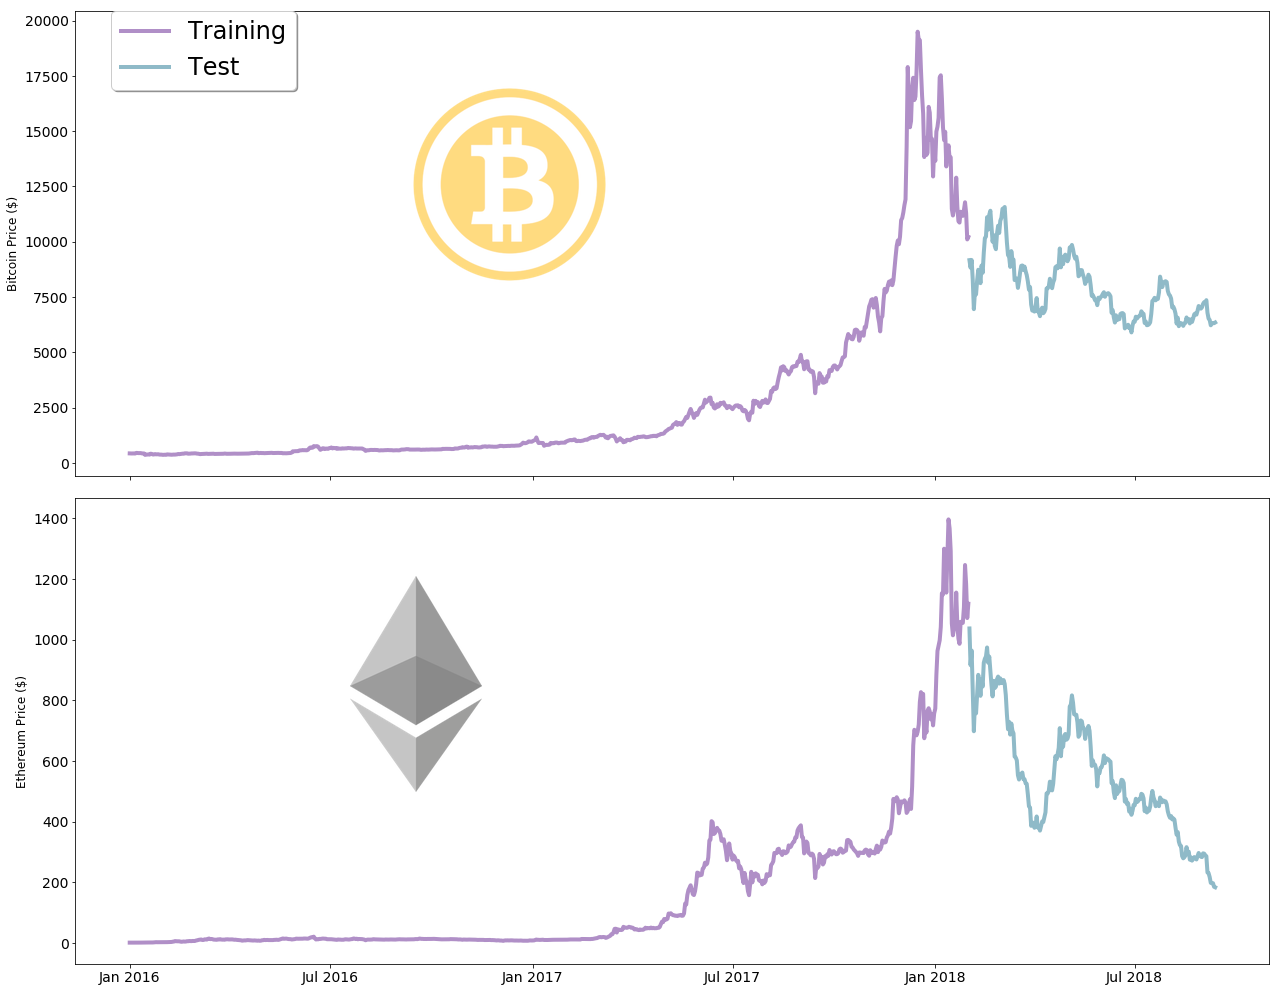

In [82]:
split_date = '2018-02-01'
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['bt_Close'], 
         color='#B08FC7', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['bt_Close'], 
         color='#8FBAC8', label='Test')
ax2.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['eth_Close'], 
         color='#B08FC7')
ax2.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['eth_Close'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 24}, shadow=True)
fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
             300, 650, zorder=3,alpha=.5)
fig.figimage(eth_im.resize((int(eth_im.size[0]*0.65), int(eth_im.size[1]*0.65)), Image.ANTIALIAS), 
             350, 200, zorder=3,alpha=.5)
plt.show()

Firstly, let's check whether the daily change in price follow a normal distribution.One way to see this is by ploting the histograms

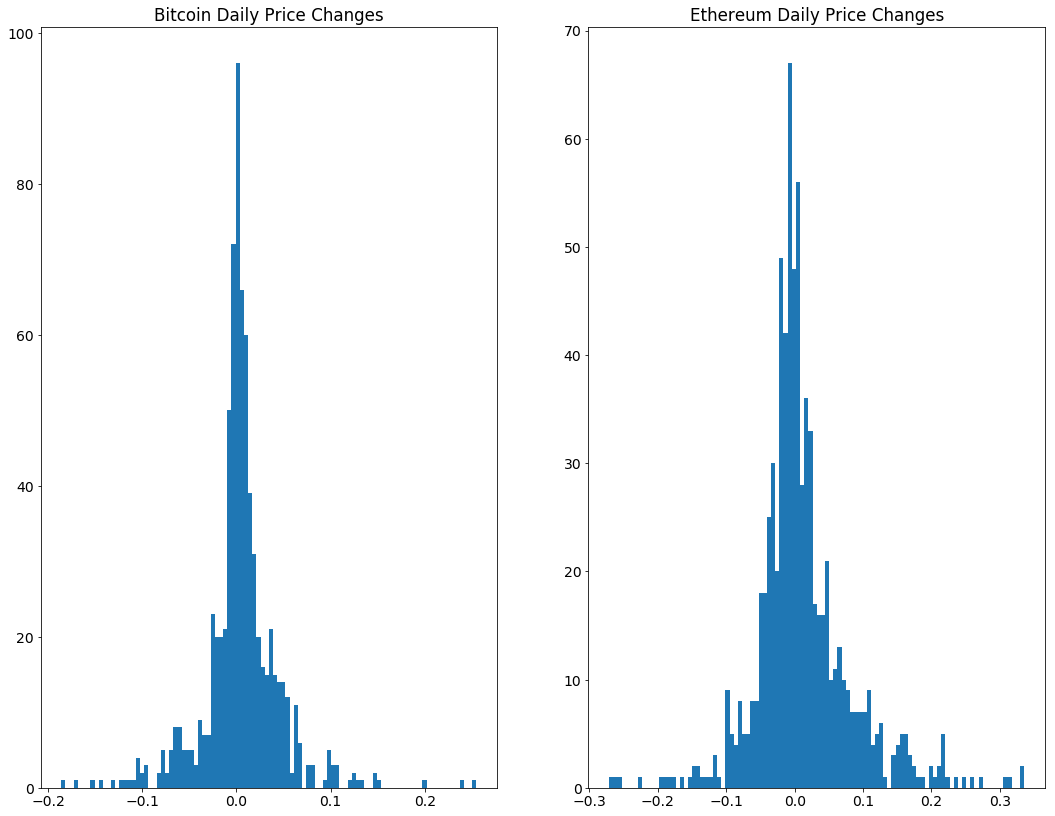

In [83]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(market_info[market_info['Date']< split_date]['bt_day_diff'].values, bins=100)
ax2.hist(market_info[market_info['Date']< split_date]['eth_day_diff'].values, bins=100)
ax1.set_title('Bitcoin Daily Price Changes')
ax2.set_title('Ethereum Daily Price Changes')
plt.show()

## Long Short Term Memory (LSTM)

For LSTM Theory read: [this](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), [this](http://blog.echen.me/2017/05/30/exploring-lstms/) and [this](http://www.bioinf.jku.at/publications/older/2604.pdf). Nevertheless, various implementations of deep learning algorithms are provided out of the box by different packages (e.g. [TensorFlow](https://www.tensorflow.org/get_started/get_started), [Keras](https://keras.io/#keras-the-python-deep-learning-library), [PyTorch](http://pytorch.org/), etc.). Here I use Keras, since it's really really convinient and was build with tensorflow in mind ;)

In [84]:
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

In [85]:
model_data = market_info[['Date']+[coin+metric for coin in ['bt_', 'eth_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.tail()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
4,2018-09-08,6225.98,3835060000,0.830962,0.052124,197.95,1517200000,0.654002,0.124409
3,2018-09-09,6300.86,3671890000,0.186745,0.039374,196.92,1585980000,0.110537,0.097590
2,2018-09-10,6329.70,3714100000,0.101435,0.013048,197.08,1502960000,-0.219512,0.062168
1,2018-09-11,6321.20,3849910000,0.120611,0.021907,185.07,1568900000,0.500838,0.090372
0,2018-09-12,6351.80,4064230000,-0.755619,0.015637,183.33,1874850000,-0.705153,0.082677


In [86]:
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [87]:
window_len = 10
norm_cols = [coin+metric for coin in ['bt_', 'eth_'] for metric in ['Close','Volume']]

In [88]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1

In [89]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['eth_Close'][window_len:].values/test_set['eth_Close'][:-window_len].values)-1

In [90]:
LSTM_training_inputs[0]

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
985,0.000000,0.000000,-0.560137,0.020268,0.000000,0.000000,-0.418477,0.025040
984,-0.002049,-0.170410,0.250597,0.009641,-0.011498,0.239937,0.965898,0.034913
983,-0.009946,0.092475,-0.173865,0.020827,0.025190,0.978201,-0.317885,0.060792
982,-0.002855,0.060603,-0.474265,0.012649,0.006810,0.680295,-0.057657,0.047943
981,-0.005457,-0.048411,-0.013333,0.010391,0.002270,0.066829,0.697930,0.025236
980,-0.012019,-0.061645,-0.003623,0.012782,0.002991,0.498534,-0.214540,0.026263
979,0.054613,1.413585,-0.951499,0.069045,-0.006349,2.142074,0.681644,0.040587
978,0.043515,0.570968,0.294196,0.032762,0.040890,1.647747,-0.806717,0.055274
977,0.030576,-0.110282,0.814194,0.017094,0.040937,0.098121,-0.411897,0.019021
976,0.031451,-0.007801,-0.919598,0.017758,0.054014,0.896944,-0.938235,0.025266


In [91]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [92]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

Using TensorFlow backend.


In [93]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 5s - loss: 0.1455
Epoch 2/50
 - 9s - loss: 0.0963
Epoch 3/50
 - 8s - loss: 0.0880
Epoch 4/50
 - 8s - loss: 0.0790
Epoch 5/50
 - 3s - loss: 0.0766
Epoch 6/50
 - 8s - loss: 0.0769
Epoch 7/50
 - 8s - loss: 0.0705
Epoch 8/50
 - 8s - loss: 0.0688
Epoch 9/50
 - 4s - loss: 0.0716
Epoch 10/50
 - 7s - loss: 0.0684
Epoch 11/50
 - 9s - loss: 0.0684
Epoch 12/50
 - 8s - loss: 0.0688
Epoch 13/50
 - 6s - loss: 0.0663
Epoch 14/50
 - 4s - loss: 0.0664
Epoch 15/50
 - 4s - loss: 0.0662
Epoch 16/50
 - 4s - loss: 0.0644
Epoch 17/50
 - 7s - loss: 0.0662
Epoch 18/50
 - 6s - loss: 0.0673
Epoch 19/50
 - 5s - loss: 0.0660
Epoch 20/50
 - 7s - loss: 0.0676
Epoch 21/50
 - 8s - loss: 0.0627
Epoch 22/50
 - 8s - loss: 0.0635
Epoch 23/50
 - 3s - loss: 0.0633
Epoch 24/50
 - 5s - loss: 0.0642
Epoch 25/50
 - 4s - loss: 0.0628
Epoch 26/50
 - 8s - loss: 0.0619
Epoch 27/50
 - 7s - loss: 0.0656
Epoch 28/50
 - 5s - loss: 0.0635
Epoch 29/50
 - 5s - loss: 0.0642
Epoch 30/50
 - 3s - loss: 0.0649
Epoch 31/50
 - 3s -

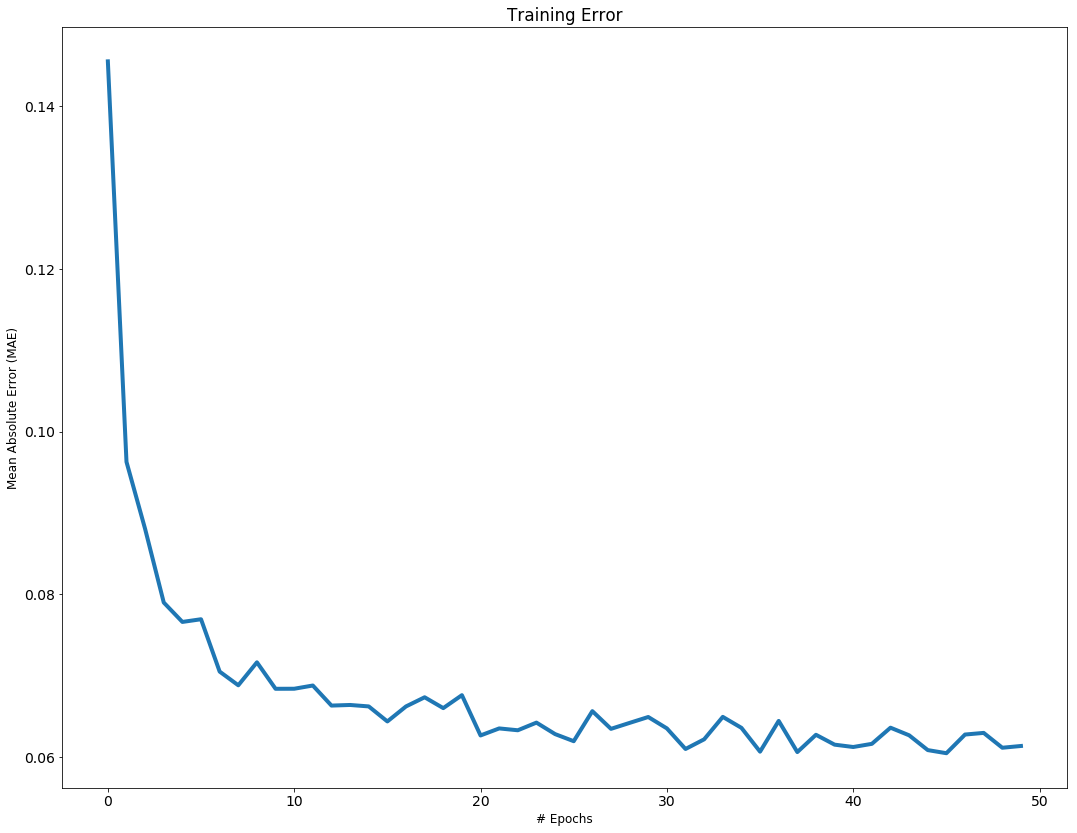

In [94]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

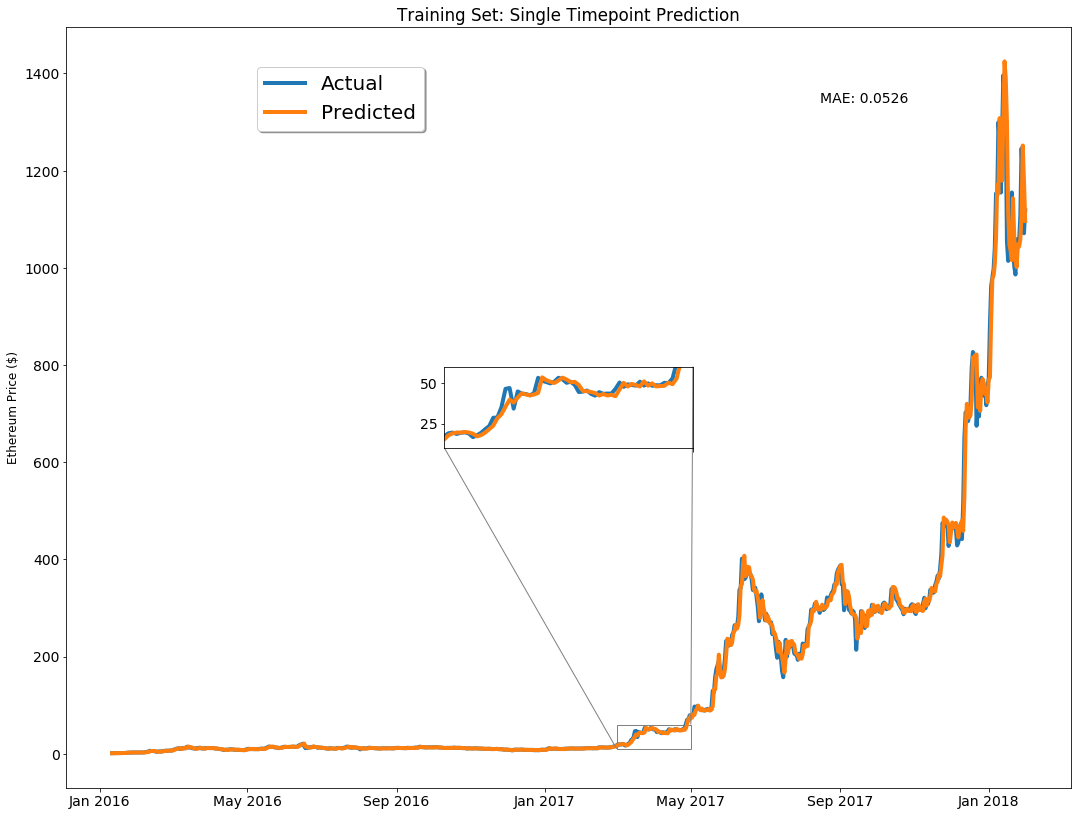

In [103]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['eth_Close'].values[window_len:])/(training_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 3.35, loc=10) # zoom-factor: 3.35, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 3, 1), datetime.date(2017, 5, 1)])
axins.set_ylim([10,60])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

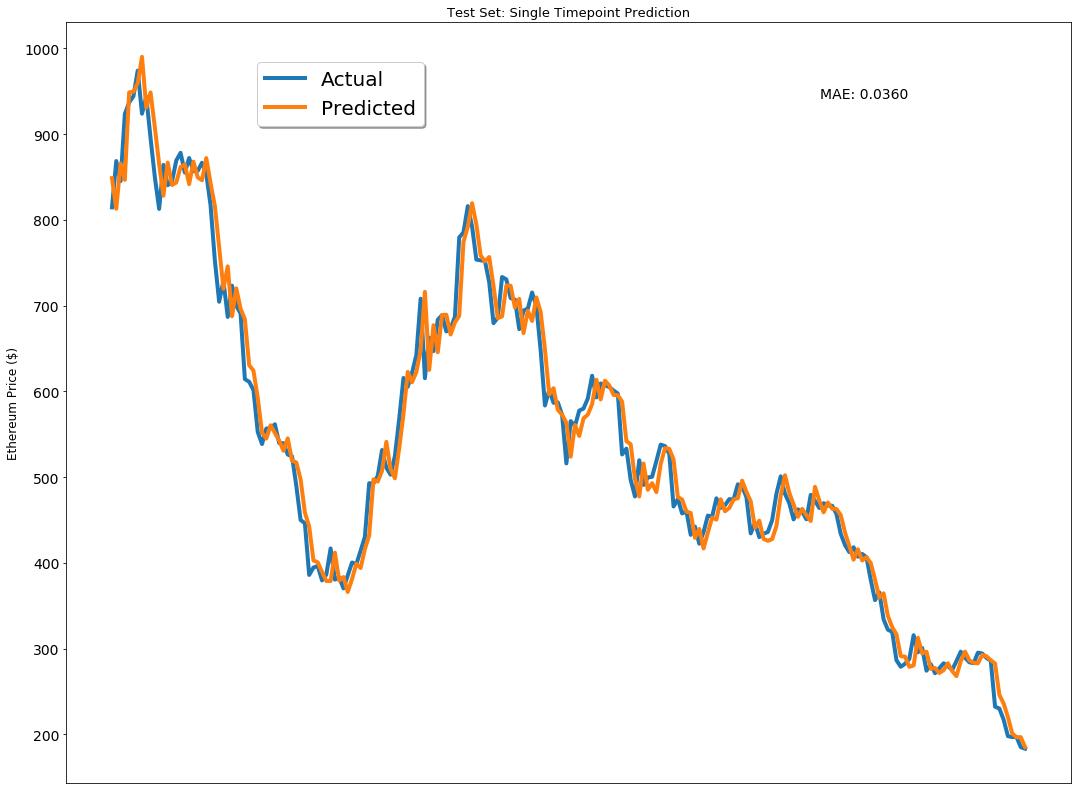

In [108]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['eth_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['eth_Close'].values[window_len:])/(test_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
plt.show()

In [105]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture for bitcoin
bt_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs, 
                            (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)
# #eth_model.save('eth_model%d.h5'%j)

Epoch 1/50
 - 4s - loss: 0.1002
Epoch 2/50
 - 6s - loss: 0.0595
Epoch 3/50
 - 8s - loss: 0.0497
Epoch 4/50
 - 6s - loss: 0.0458
Epoch 5/50
 - 9s - loss: 0.0420
Epoch 6/50
 - 7s - loss: 0.0422
Epoch 7/50
 - 9s - loss: 0.0390
Epoch 8/50
 - 3s - loss: 0.0373
Epoch 9/50
 - 3s - loss: 0.0368
Epoch 10/50
 - 10s - loss: 0.0352
Epoch 11/50
 - 11s - loss: 0.0356
Epoch 12/50
 - 4s - loss: 0.0356
Epoch 13/50
 - 3s - loss: 0.0336
Epoch 14/50
 - 3s - loss: 0.0337
Epoch 15/50
 - 8s - loss: 0.0342
Epoch 16/50
 - 8s - loss: 0.0338
Epoch 17/50
 - 5s - loss: 0.0341
Epoch 18/50
 - 3s - loss: 0.0349
Epoch 19/50
 - 3s - loss: 0.0340
Epoch 20/50
 - 3s - loss: 0.0331
Epoch 21/50
 - 8s - loss: 0.0331
Epoch 22/50
 - 6s - loss: 0.0328
Epoch 23/50
 - 4s - loss: 0.0328
Epoch 24/50
 - 4s - loss: 0.0340
Epoch 25/50
 - 4s - loss: 0.0324
Epoch 26/50
 - 4s - loss: 0.0318
Epoch 27/50
 - 4s - loss: 0.0331
Epoch 28/50
 - 4s - loss: 0.0326
Epoch 29/50
 - 4s - loss: 0.0329
Epoch 30/50
 - 4s - loss: 0.0325
Epoch 31/50
 - 4s

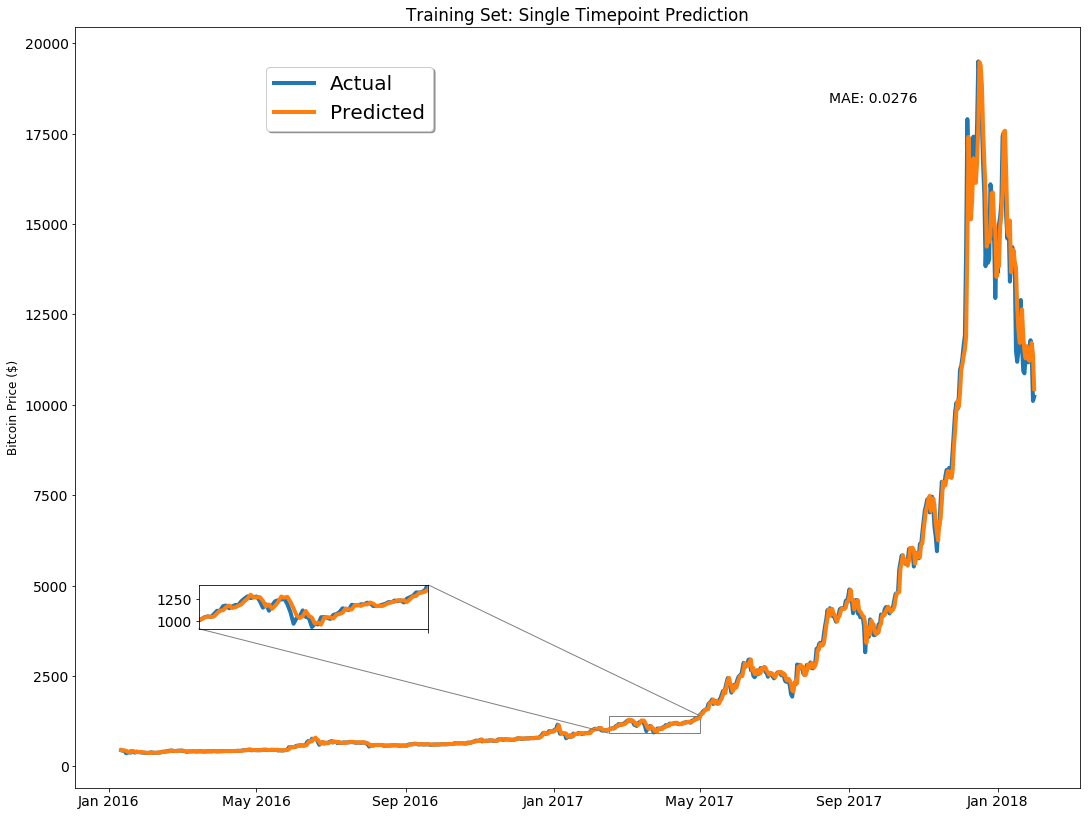

In [109]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_Close'].values[window_len:])/(training_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 2.52, loc=10, bbox_to_anchor=(400, 307)) # zoom-factor: 2.52, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 2, 15), datetime.date(2017, 5, 1)])
axins.set_ylim([920, 1400])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

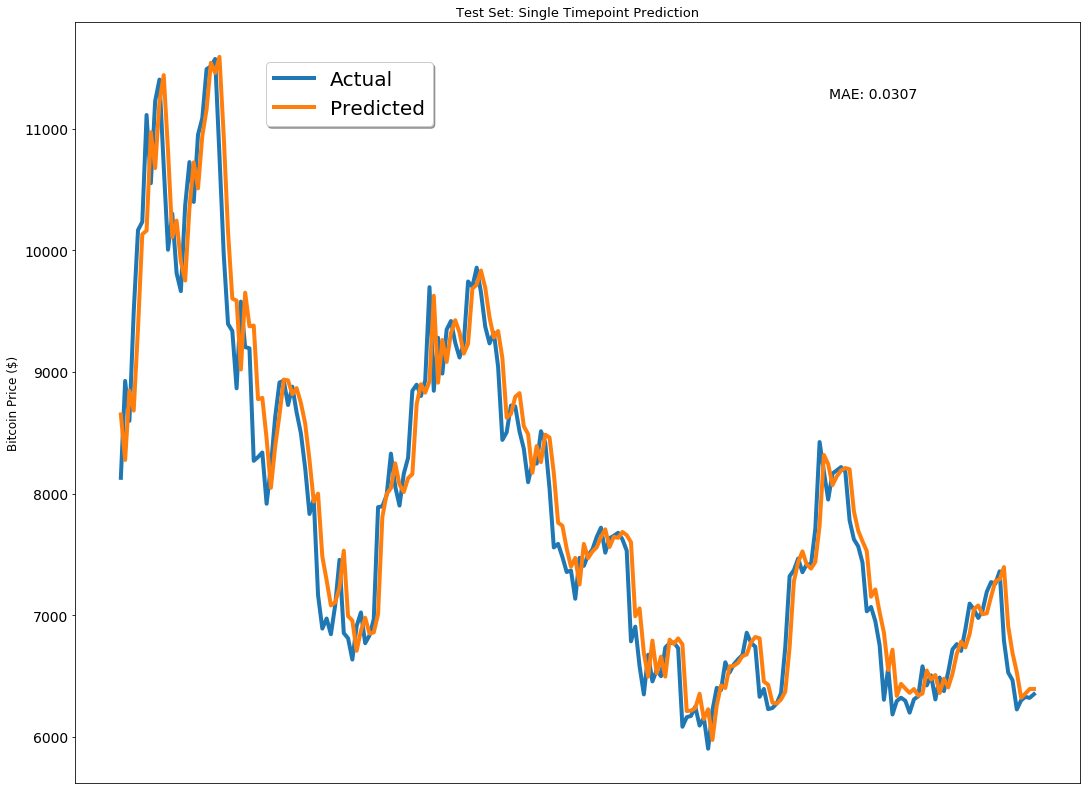

In [110]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_Close'].values[window_len:])/(test_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
plt.show()

In [111]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next week 
# change this value if you want to make longer/shorter prediction
pred_range = 7
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 7 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['eth_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['eth_Close'][i:i+pred_range].values/
                                  training_set['eth_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 6s - loss: 0.2074
Epoch 2/50
 - 5s - loss: 0.1560
Epoch 3/50
 - 4s - loss: 0.1472
Epoch 4/50
 - 6s - loss: 0.1428
Epoch 5/50
 - 7s - loss: 0.1387
Epoch 6/50
 - 9s - loss: 0.1367
Epoch 7/50
 - 5s - loss: 0.1337
Epoch 8/50
 - 4s - loss: 0.1324
Epoch 9/50
 - 7s - loss: 0.1332
Epoch 10/50
 - 9s - loss: 0.1288
Epoch 11/50
 - 8s - loss: 0.1307
Epoch 12/50
 - 4s - loss: 0.1294
Epoch 13/50
 - 4s - loss: 0.1286
Epoch 14/50
 - 7s - loss: 0.1283
Epoch 15/50
 - 4s - loss: 0.1298
Epoch 16/50
 - 4s - loss: 0.1257
Epoch 17/50
 - 8s - loss: 0.1266
Epoch 18/50
 - 6s - loss: 0.1285
Epoch 19/50
 - 4s - loss: 0.1254
Epoch 20/50
 - 5s - loss: 0.1287
Epoch 21/50
 - 5s - loss: 0.1251
Epoch 22/50
 - 8s - loss: 0.1253
Epoch 23/50
 - 9s - loss: 0.1289
Epoch 24/50
 - 6s - loss: 0.1232
Epoch 25/50
 - 7s - loss: 0.1214
Epoch 26/50
 - 5s - loss: 0.1225
Epoch 27/50
 - 5s - loss: 0.1222
Epoch 28/50
 - 4s - loss: 0.1219
Epoch 29/50
 - 6s - loss: 0.1196
Epoch 30/50
 - 7s - loss: 0.1200
Epoch 31/50
 - 5s -

In [113]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 7
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 7 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_Close'][i:i+pred_range].values/
                                  training_set['bt_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 4s - loss: 0.1088
Epoch 2/50
 - 5s - loss: 0.0817
Epoch 3/50
 - 5s - loss: 0.0731
Epoch 4/50
 - 4s - loss: 0.0701
Epoch 5/50
 - 5s - loss: 0.0667
Epoch 6/50
 - 4s - loss: 0.0657
Epoch 7/50
 - 3s - loss: 0.0658
Epoch 8/50
 - 3s - loss: 0.0640
Epoch 9/50
 - 3s - loss: 0.0631
Epoch 10/50
 - 10s - loss: 0.0621
Epoch 11/50
 - 8s - loss: 0.0630
Epoch 12/50
 - 5s - loss: 0.0641
Epoch 13/50
 - 4s - loss: 0.0637
Epoch 14/50
 - 3s - loss: 0.0634
Epoch 15/50
 - 5s - loss: 0.0618
Epoch 16/50
 - 5s - loss: 0.0619
Epoch 17/50
 - 5s - loss: 0.0614
Epoch 18/50
 - 4s - loss: 0.0610
Epoch 19/50
 - 4s - loss: 0.0621
Epoch 20/50
 - 4s - loss: 0.0621
Epoch 21/50
 - 4s - loss: 0.0602
Epoch 22/50
 - 3s - loss: 0.0629
Epoch 23/50
 - 3s - loss: 0.0613
Epoch 24/50
 - 3s - loss: 0.0601
Epoch 25/50
 - 4s - loss: 0.0595
Epoch 26/50
 - 4s - loss: 0.0612
Epoch 27/50
 - 4s - loss: 0.0598
Epoch 28/50
 - 4s - loss: 0.0602
Epoch 29/50
 - 4s - loss: 0.0594
Epoch 30/50
 - 4s - loss: 0.0592
Epoch 31/50
 - 4s 

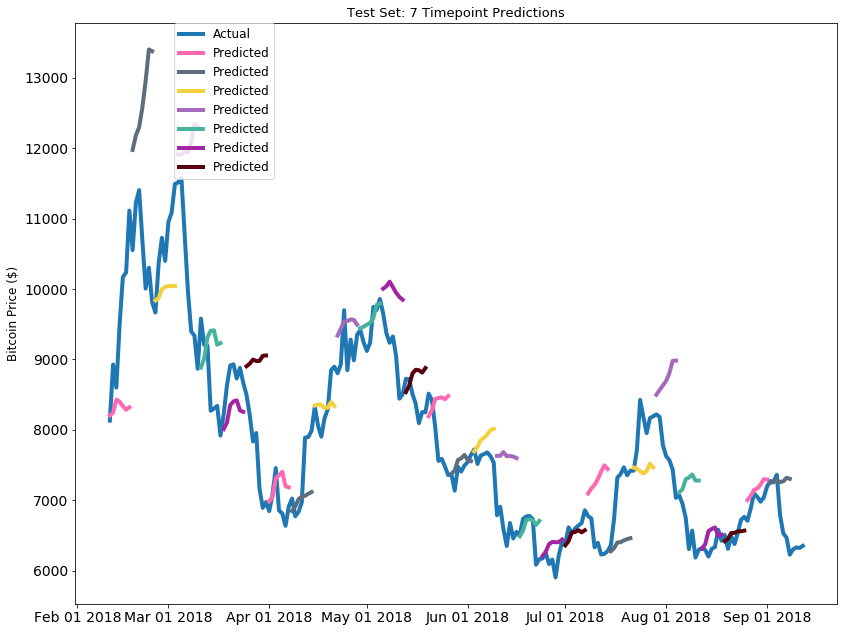

In [121]:
# little bit of reformatting the predictions to closing prices
# eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
#                    test_set['eth_Close'].values[:-(window_len + pred_range)][::7].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))
bt_pred_prices = ((bt_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['bt_Close'].values[:-(window_len + pred_range)][::7].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D", '#a324a5', '#59020c']
fig, (ax1) = plt.subplots(1,1)

fig_size = plt.rcParams["figure.figsize"]
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
# ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')
# ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
#          test_set['eth_Close'][window_len:], label='Actual')
for i, (bt_pred) in enumerate(bt_pred_prices):
    # Only adding lines to the legend once
    if i<7:
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%7], label="Predicted")
    else: 
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%7])
#     ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
#              eth_pred, color=pred_colors[i%5])
ax1.set_title('Test Set: 7 Timepoint Predictions',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
# ax1.set_xticklabels('')
# ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
fig.tight_layout()
plt.show()

The predictions are visibly less impressive than their single point counterparts. Nevertheless, I'm pleased that the model returned somewhat nuanced behaviours (e.g. the second line on the eth graph); it didn't simply forecast prices to move uniformly in one direction. So there are some grounds for optimism.

Moving back to the single point predictions, our deep machine artificial neural model looks okay, but so did that boring random walk model. Like the random walk model, LSTM models can be sensitive to the choice of random seed (the model weights are initially randomly assigned). So, if we want to compare the two models, we'll run each one multiple (say, 25) times to get an estimate for the model error. The error will be calculated as the absolute difference between the actual and predicted closing prices changes in the test set.

## Summary

All in all, we collected some crypto data and fed it into LSTM deep layered network, you definitely don't have to be an expert to make use of keras, although I am suspicious whether you'd feel good without understanding any bit of it.
I do feel sceptic on LSTM though, and will try GRU and min GRU, also I will have to make a yearly prediction, which in my opinion is scary considering the volatility of the market.
I will always tweak the model by:

* **Changing Loss Functions**: MAE doesn't really encourage risk taking. For example, under mean squared error (MSE), the LSTM model would be forced to place more importance on detecting spikes/troughs. [More bespoke trading focused loss functions](http://www.faculty.ucr.edu/~taelee/paper/lossfunctions.pdf) could also move the model towards less conservative behaviours.

* **Get more and/or better data**: If past prices alone are sufficient to decently forecast future prices, we need to include other features that provide comparable predictive power. That way, the LSTM model wouldn't be so reliant on past prices, potentially unlocking more complex behaviours. This is probably the best and hardest solution.

I will also try to use [Facebook Prophet Algorithm](https://github.com/facebook/prophet), I feel really intrigued by it since it targets time-series only!